# 833-JinxML - NN Test

## Experiments

```
In = Min Spawn, Out = Player X
0.0207730233669281
x = relu(fc1(x))
x = sigmoid(fc2(x))

0.028059059754014015
x = sigmoid(fc1(x))
```

## Load Dataset

In [13]:
from tlol.datasets.replay_dataset import *
dataset = TLoLReplayDataset("./full_db")

## Dataset

Features with highest correlation with player X
- time
- min spawn
- 

In [14]:
tm_x_s = []
tm_y_s = []

for i in range(1): # len(dataset)
    cur  = dataset[i]

    tm_x = [cur["raw"].iloc[:, 1:2]]
    tm_x = np.array(tm_x) / 60.0 # min spawn
    tm_x = torch.Tensor(tm_x)

    tm_y = [cur["champs"].iloc[:, 7:8]]
    tm_y = np.array(tm_y) / 16000.0 # player x pos
    tm_y = torch.Tensor(tm_y)
    
    tm_x_s.append(tm_x)
    tm_y_s.append(tm_y)

tm_x_s[0].shape

torch.Size([1, 1410, 1])

## Model

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

seed = 1
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

class TimePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 2)
        self.fc2 = nn.Linear(2, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

model = TimePredictor()

## Training

c:\Users\win8t\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1000 0.03658668324351311 tensor([[[59.7070],
         [58.5645],
         [58.3008],
         ...,
         [ 5.7898],
         [ 5.5481],
         [ 5.3247]]], device='cuda:0') tensor([[[  131.9580],
         [  131.9580],
         [  131.9580],
         ...,
         [12039.0625],
         [12039.0625],
         [12039.0625]]], device='cuda:0') tensor([[[6456.5796],
         [6492.1089],
         [6504.5039],
         ...,
         [8816.9717],
         [8821.9873],
         [8825.9990]]], device='cuda:0', grad_fn=<MulBackward0>)
2000 0.03285576030611992 tensor([[[59.7070],
         [58.5645],
         [58.3008],
         ...,
         [ 5.7898],
         [ 5.5481],
         [ 5.3247]]], device='cuda:0') tensor([[[  131.9580],
         [  131.9580],
         [  131.9580],
         ...,
         [12039.0625],
         [12039.0625],
         [12039.0625]]], device='cuda:0') tensor([[[6145.4688],
         [6192.7212],
         [6202.5146],
         ...,
         [9389.4238],
         [9

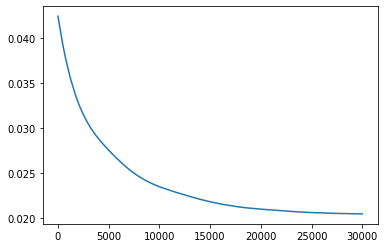

In [29]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.cuda.amp.grad_scaler import GradScaler

criterion = nn.MSELoss()
lr = 0.0001 # 0.0001 # 
optimizer = optim.Adam(model.parameters(), lr=lr)
batch_size = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

train_loader = torch.utils.data.DataLoader(
    dataset,
    shuffle=False,
    pin_memory=(device=="cuda"),
    num_workers=6,
    batch_size=batch_size,
    collate_fn=dataset.collate_fixed_length)

amp = False
scaler = GradScaler()

n_epochs = 30_000

losses = []

for epoch in range(1, n_epochs + 1):
    for tm_x, tm_y in zip(tm_x_s, tm_y_s):
        optimizer.zero_grad()

        tm_x = tm_x.to(device)
        tm_y = tm_y.to(device)

        preds = model(tm_x)

        # print(preds, tm_x, tm_y)

        loss = criterion(preds, tm_y)
        losses.append(loss.cpu().detach().numpy())
        
        loss.backward()
        optimizer.step()

    if epoch % 1000 == 0:
        print(epoch, loss.item(), tm_x * 60, tm_y * 16000, preds * 16000)

plt.plot(losses)